In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# We need to join the upper directory in order to access the local modules
import datetime
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [5]:
from pytdoa import nonlinoptim, linoptim, brutefoptim
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT
from pytdoa.geometry import generate_heatmap

from pytdoa.helpers import moving_average

In [4]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

In [5]:
# Reading the mat files
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])
center = gNBs[3,:]
Rba = np.array([[np.cos(np.pi/2),-np.sin(np.pi/2),center[0]],[np.sin(np.pi/2),np.cos(np.pi/2),center[1]],[0.0,0.0,1.0]])
Rab = np.linalg.inv(Rba)

ggs = np.hstack((gNBs,np.ones((4,1))))
gNBs = np.matmul(Rab,ggs.T).T
gNBs = gNBs[:,0:2]

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

uus = np.hstack((UEs,np.ones((6,1))))

UEs = np.matmul(Rab,uus.T).T
UEs = UEs[:,0:2]

## Positioning results for all positions

In [45]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = [122.88e6 if frequency_mhz == 100 else 61.44e6]
ma_window = 70
ngnb = 4

npoints = 1200
l = 1.0
x = (np.min(gNBs[:,0])-l,np.max(gNBs[:,0])+l)
y = (np.min(gNBs[:,1])-l,np.max(gNBs[:,1])+l)

# f_cor = 1.0000008 # real pps

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
n = 4  # We will use 4 gNBs except for position 4 & 40 MHz examples
for position in range(0, 6):
    # Reading and filtering
    df = pd.read_csv(f"comnets_data/experiments/exp{position}/{frequency_mhz}mhz.csv")
    df.drop(
        [
            "Unnamed: 0",
        ],
        axis=1,
        inplace=True,
    )

    # This is internal knowledge
    if frequency_mhz == 100:
        if ngnb == 4:
            gnbs = gNBs
        else:
            df.drop(["gNB2", "P2"], axis=1, inplace=True)
            n = 3
            gnbs = gNBs[1:]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

        if position == 1:
            df_filt = df_filt.loc[154:]  # Only for Position 1

    elif frequency_mhz == 40:
        n = 3
        if position != 2:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            gnbs = gNBs[1:, :]
        else:
            df.drop(["gNB1", "P1"], axis=1, inplace=True)
            gnbs = gNBs[[0, 2, 3], :]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

    else:
        raise RuntimeError("Unsupported frequency")

    # Calculating the theoretical values
    th_toa = np.linalg.norm(UEs[position] - gnbs, axis=1)
    th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
    result_dict[f"P{position}", "th_tdoa"] = th_tdoa

    # Vectorized version to obtain TDOA values
    if frequency_mhz == 100:
        if ngnb == 4:
            toas = df_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            toas = df_filt[["gNB0", "gNB1", "gNB3"]].to_numpy()
    elif frequency_mhz == 40:
        if position == 1:
            continue
        elif position != 2:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            toas = df_filt[["gNB0", "gNB2", "gNB3"]].to_numpy()
    else:
        raise RuntimeError("Unsupported frequency")

    triu_indices = np.triu_indices(n, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]

    # A bit of masking to remove obvious outliers
    maskl, masku = (tdoas > -7), tdoas < 7
    mask = (maskl & masku).all(axis=1)
    tdoas = moving_average(tdoas[mask, :], ma_window)

    tdoas = tdoas / frequency * SPEED_OF_LIGHT
    tdoas_mean = np.mean(tdoas, axis=0)

    # Let's start the positioning routines
    combination_range = itertools.combinations(np.arange(len(gnbs)), 2)
    combinations = np.fromiter(combination_range, dtype=np.dtype((int, 2)))

    mse = []
    for experiment in range(len(tdoas)):

        heatmap = generate_heatmap(tdoas[experiment,:],gNBs,x,y,combinations,npoints,filter=False)
        id = np.argmax(heatmap[:,2])
        res = heatmap[id,0:2]
        mse.append(res)
    
    result_dict[f'P{position}','mse'] = np.array(mse)
    print(f"Finished P{position} - Processed {len(tdoas)} points.")

now = round(datetime.datetime.now().timestamp())
with open(f'comnets_data/results/experiments/heatmap_{n}_{frequency_mhz}mhz_window_{ma_window}.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Finished P0 - Processed 664 points.
Finished P1 - Processed 664 points.
Finished P2 - Processed 1256 points.
Finished P3 - Processed 862 points.
Finished P4 - Processed 1192 points.
Finished P5 - Processed 301 points.


## Processing the results

In [46]:
import pickle
frequency_mhz = 100

with open('comnets_data/results/experiments/heatmap_4_100mhz_window_50.pickle', 'rb') as p:
        data_no_offset = pickle.load(p)

In [47]:
mse = np.array([])

for i in range(UEs.shape[0]):
    if frequency_mhz == 40 and i == 1:
        continue
    ue = UEs[i]
    m = data_no_offset[f'P{i}','mse']

    emse = np.linalg.norm(ue-m,axis=1)

    mse = np.append(mse, emse)

# mse = mse[mse < 100]


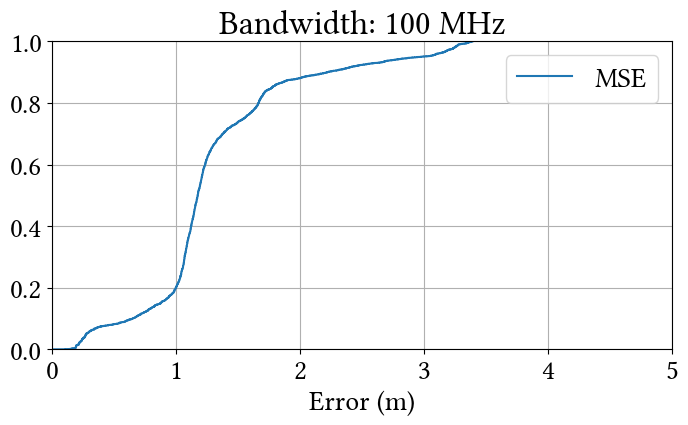

In [48]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(mse)

ax.set_xlim([0,5])
ax.grid()

ax.set_title(f'Bandwidth: {frequency_mhz} MHz')
ax.set_xlabel('Error (m)')
ax.legend(['MSE'])

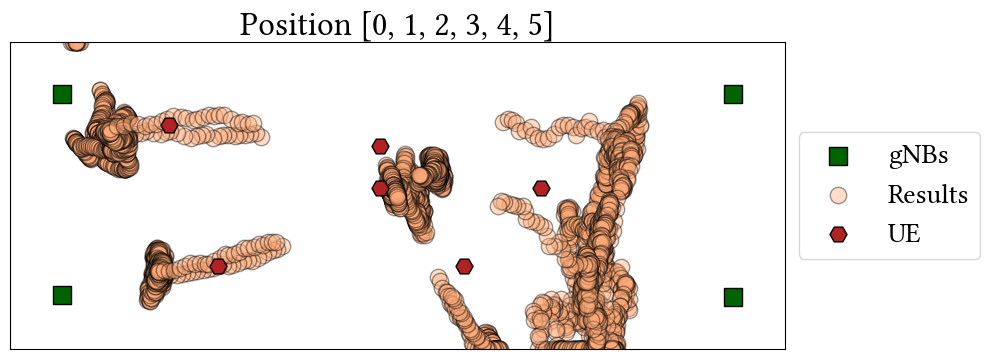

In [49]:
poss = [0,1,2,3,4,5]

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xticks([])
ax.set_yticks([])

ax.scatter(gNBs[:,0], gNBs[:,1], 180, 'darkgreen', 's', edgecolors='black')

for pos in poss:
    pts = data_no_offset[f'P{pos}','mse']
    ax.scatter(pts[:,0], pts[:,1], 140, '#ffaa77', 'o', alpha=.4, edgecolors='black')

    ax.scatter(UEs[pos,0],UEs[pos,1], 150, 'firebrick', 'H', edgecolors='black')


ax.set_xlim([np.min(gNBs[:,0])-1.0, np.max(gNBs[:,0])+1.0])
ax.set_ylim([np.min(gNBs[:,1])-1.0, np.max(gNBs[:,1])+1.0])

ax.legend(('gNBs','Results','UE'), loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title(f'Position {poss}')

plt.gca().set_aspect('equal')
plt.show()

In [142]:
gNBs

array([[ 1.28100000e+01, -3.00000000e-02],
       [ 1.28100000e+01,  3.84000000e+00],
       [-2.35132185e-16,  3.84000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])